In [1]:
import os
from copy import deepcopy

import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
df_X = pd.read_csv("./data/x_train.csv", header=None)
df_y = pd.read_csv("./data/y_train.csv", header=None)

In [4]:
np_X = df_X.to_numpy()
np_y = df_y.to_numpy()[:, 0]

In [5]:
median_y = np.median(np_y)
median_y

np.float64(-17.556392250000002)

In [6]:
# rate - доля точек, которые мы отнесем к первой группе 
# В данном случае rate=0.5, т.е. точек в двух группах поровну
rate = 0.5
# Производим разбиение точек по степени близости y к median_y
# Для нахождения необходимого значения используем бинарный поиск по ответу
L_d, R_d = 0, np.max(np_y) - np.min(np_y)
for i in range(200):
    M_d = (L_d + R_d) / 2
    np_X_0, np_X_1 = [], []
    np_y_0, np_y_1 = [], []
    for i in range(np_X.shape[0]):
        if median_y - M_d <= np_y[i] <= median_y + M_d:
            np_X_0.append(np_X[i])
            np_y_0.append(np_y[i])
        else:
            np_X_1.append(np_X[i])
            np_y_1.append(np_y[i])
    if len(np_y_0) / len(np_y) < rate:
        L_d = M_d
    else:    
        R_d = M_d
d_y = M_d

np_X_0, np_X_1 = [], []
np_y_0, np_y_1 = [], []
# Значения массива np_y_bin отражают, к какой из групп относится точка
# 0 - первая группа
# 1 - вторая группа
# Этот массив необходим для обучения и проверки нейросети
np_y_bin = []
for i in range(np_X.shape[0]):
    if median_y - M_d <= np_y[i] <= median_y + M_d:
        np_X_0.append(np_X[i])
        np_y_0.append(np_y[i])
        np_y_bin.append(0)
    else:
        np_X_1.append(np_X[i])
        np_y_1.append(np_y[i])
        np_y_bin.append(1)
np_X_0 = np.array(np_X_0)
np_y_0 = np.array(np_y_0)
np_X_1 = np.array(np_X_1)
np_y_1 = np.array(np_y_1)
np_y_bin = np.array(np_y_bin)

In [7]:
# Выводим данные о классификации
print(f"median_y: {round(median_y)}, d_y: {round(d_y)}, rate = {rate}")
print(f"Len_0 = {len(np_y_0)}, Len_1 = {len(np_y_1)}")

median_y: -18, d_y: 72, rate = 0.5
Len_0 = 150, Len_1 = 150


Обучим нейронную сеть для задачи регрессии точек группы 0 (близкие к медианному значению)

In [8]:
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return torch.tensor(self.X[i]).float(), torch.tensor(self.y[i]).float()

In [10]:
class NNRegression:
    def __init__(self, n_hidden=128, n_hidden_layers=2, lr=1e-3, n_epochs=200, batch_size=32, sigmoid_rate=0):
        self.n_hidden = n_hidden
        self.n_hidden_layers = n_hidden_layers
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        # sigmoid_rate - доля sigmoid среди функций активации
        self.sigmoid_rate = sigmoid_rate
        self.model = None
        self.train_loss = None
        self.val_loss = None
    
    def fit(self, X_train, y_train, X_val, y_val):
        n_val_X = X_train.shape[-1]
        n_val_y = y_train.shape[-1]

        lawyers = [nn.Linear(n_val_X, self.n_hidden), nn.ReLU()]
        for i in range(self.n_hidden_layers):
            lawyers.append(nn.Linear(self.n_hidden, self.n_hidden))
            if random.random() < self.sigmoid_rate:
                lawyers.append(nn.Sigmoid())
            else:
                lawyers.append(nn.ReLU())
        lawyers.append(nn.Linear(self.n_hidden, n_val_y))
        self.model = nn.Sequential(*lawyers)
        
        optim = Adam(self.model.parameters(), lr=self.lr)
        dataset = RegressionDataset(X_train, y_train)
        dataloader = DataLoader(dataset, shuffle=True, batch_size=self.batch_size)
        self.train_loss = []

        val_dataset = RegressionDataset(X_val, y_val)
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size)
        self.val_loss = []

        best_model = None
        best_num_epoch = None
        best_val_loss = None
        
        for epoch in range(1, self.n_epochs + 1):
            losses = []
            for x_batch, y_batch in dataloader:
                y_pred = self.model(x_batch)
                loss = F.mse_loss(y_pred, y_batch)
                optim.zero_grad()
                loss.backward()
                optim.step()
                losses.append(loss.detach().item())
            self.train_loss.append(np.mean(losses))

            with torch.no_grad():
                losses = []
                for x_batch, y_batch in val_dataloader:
                    y_pred = self.model(x_batch)
                    loss = F.mse_loss(y_pred, y_batch)
                    losses.append(loss.detach().item())
                self.val_loss.append(np.mean(losses))
            
            if best_val_loss == None or best_val_loss > self.val_loss[-1]:
                best_val_loss = self.val_loss[-1]
                best_num_epoch = epoch
                best_model = deepcopy(self.model)
            if epoch % 100 == 0:
                # Вывод сведений о процессе обучения
                print(f"Epoch {epoch}, loss {round(self.val_loss[-1])}")
        self.model = deepcopy(best_model)
        # Лучшая модель
        print(f"Best loss was at {best_num_epoch} epoch: {round(best_val_loss)}")

    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X).float()
            y = self.model(X).numpy()
            return y

In [9]:
# Гиперпараметры
n_hidden_0 = 15
n_hidden_layers_0 = 3
lr_0 = 3e-4
n_epochs_0 = 500
batch_size_0 = 1
sigmoid_rate_0 = 0.1

In [11]:
X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(np_X_0, np_y_0, test_size=0.4, random_state=42)

In [13]:
# Убираем лишнюю размерность
y_train_0 = y_train_0.reshape(-1, 1)
y_val_0 = y_val_0.reshape(-1, 1)

In [28]:
model_0 = NNRegression(n_hidden=n_hidden_0, n_hidden_layers=n_hidden_layers_0, lr=lr_0, n_epochs=n_epochs_0, batch_size=batch_size_0, sigmoid_rate=sigmoid_rate_0)
model_0.fit(X_train_0, y_train_0, X_val_0, y_val_0)


Epoch 100, loss 324
Epoch 200, loss 263
Epoch 300, loss 289
Epoch 400, loss 309
Epoch 500, loss 316
Best loss was at 215 epoch: 253


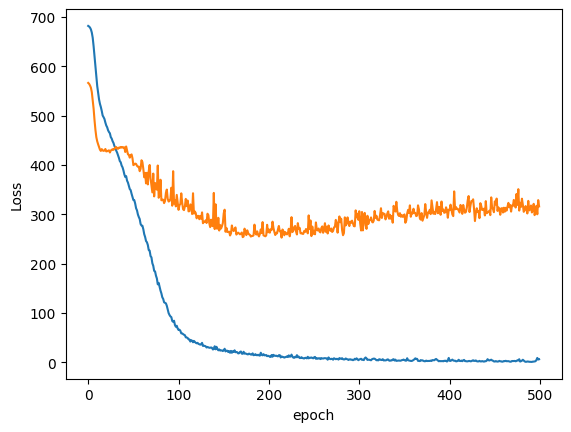

In [ ]:
# График функции потерь на тренировочной и валидационной выборках

# Начинаем строить график, начиная с конкретной эпохи
cut_start_0 = 0
# Начинаем строить график, заканчивая конкретной эпохой
cut_end_0 = 0
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(np.arange(int(len(model_0.train_loss) * cut_start_0), len(model_0.train_loss) - int(len(model_0.train_loss) * cut_end_0)), 
         model_0.train_loss[int(len(model_0.train_loss) * cut_start_0):len(model_0.train_loss) - int(len(model_0.train_loss) * cut_end_0)])
plt.plot(np.arange(int(len(model_0.val_loss) * cut_start_0), len(model_0.val_loss) - int(len(model_0.val_loss) * cut_end_0)), 
         model_0.val_loss[int(len(model_0.val_loss) * cut_start_0):len(model_0.val_loss) - int(len(model_0.val_loss) * cut_end_0)])

In [30]:
print(f"MSE: {round(mean_squared_error(y_val_0, model_0.predict(X_val_0)))}")

MSE: 253


In [ ]:
cur = 0
for file_name in os.listdir("./models_0"):
    if file_name.startswith("model_0") and file_name.endswith('.pth'):
        cur += 1
# Сохраняем модель
torch.save(model_0, f"./models_0/model_0_{cur}.pth")
# Сохраняем информацию о гиперпараметрах модели
with open("./models_0/info.txt", 'a') as f:
    print(f"{cur}. n_hidden = {n_hidden_0}, n_hidden_layers = {n_hidden_layers_0}, lr = {lr_0}, n_epochs = {n_epochs_0}, batch_size = {batch_size_0}, sigmoid_rate = {sigmoid_rate_0}, MSE: {round(mean_squared_error(y_val_0, model_0.predict(X_val_0)))}", file=f)
